In [7]:
import numpy as np 
import matplotlib.pyplot as plt 
import os
from scipy.optimize import curve_fit

os.getcwd()

'C:\\Users\\JAAL_\\Documents\\ODMR-jupyter-calculo-magnetometria\\Datos-para-magnetometria\\odmrsc-corte'

In [8]:
# Para regresar a la carpeta
os.chdir('C:/Users/JAAL_/Documents/Sincronizar_Drive/Tesis/codigos-jupyter/Magnetometria-NV/')

# Cargando la data obtenida del experimento para ODMR sin campo

C:\Users\JAAL_\AppData\Local\Temp\ipykernel_6136\4092063161.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imag = imread(file[i][j])


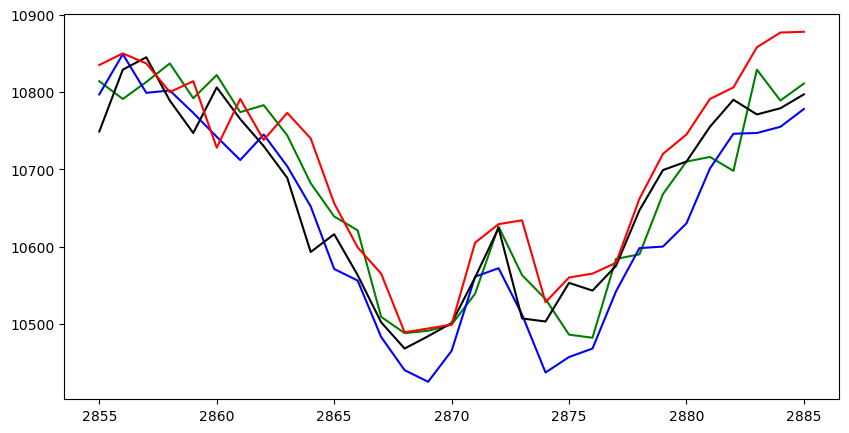

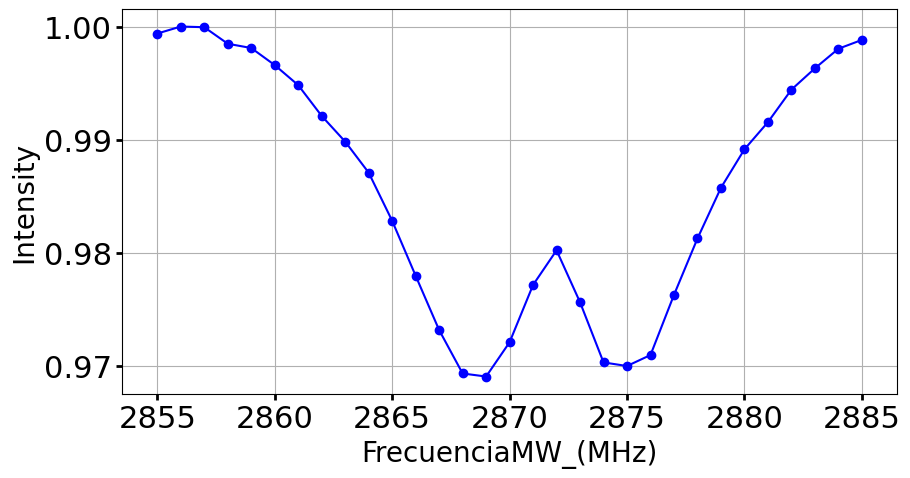

In [9]:
from imageio import imread
import glob

os.chdir('C:/Users/JAAL_/Documents/ODMR-jupyter-calculo-magnetometria/Datos-para-magnetometria/odmrsc-corte')
# ahora si se ubica en la carpeta una

########################## LECTURA ################################

# numero de medias 
nmedias = 64
file = list()
for i in range(1,nmedias+1):
    # devuelve la ruta especificada de datos
    file.append(glob.glob(str(i)+'_image_*.png'))

######################## FRECUENCIAS ###############################
    
my_range=np.arange(2870-15,2870+16,1)
x1 = [x for x in my_range] # El rango de frecuencias de las fotos en una lista

######################## Suma de la región de interes ##########################
'''
i = En el for indica el numero de experimento 
j = Indica el numero de frecuencia en la foto

Para hacer la modificación solo debo agarrar una zona de interes
'''

ODMR = []
for i in range(nmedias):
    n = list()
    for j in range(len(x1)):
        imag = imread(file[i][j])
        
        
        n.append(np.sum(imag))
    ODMR.append(n)

########### Grafica de algunos datos ########
plt.figure(figsize = (10,5))
plt.plot(x1,ODMR[4],'-g')
plt.plot(x1,ODMR[5],'-b')
plt.plot(x1,ODMR[6],'-k')
plt.plot(x1,ODMR[7],'-r')
plt.show()

######## Esto de aca se puede reducir a una sola linea (quien hizo este codigo :( )
nt = list()
for i in range(len(x1)):
    soma = 0
    for j in range(nmedias):
        soma = soma + ODMR[j][i]
    nt.append(soma)
    
Nnt = list()
norm = float(max(nt))
for i in range(len(x1)):
    Nnt.append(nt[i]/norm) # normalizmos

A = []
for i in range(len(x1)):
	A.append([0]*2)
for i in range(len(x1)):
	A[i][0] = x1[i]
	A[i][1] = Nnt[i]

np.savetxt('ODMR-15dBm.txt',A,fmt='%s') # Lo guardamos aqui y esto es lo que usaremos en el futuro
    
plt.figure(figsize = (10,5))
plt.plot(x1,Nnt,'-ob')
plt.tick_params(direction='out', length=4, width=2, colors='black',labelsize=22)
plt.xlabel('FrecuenciaMW_(MHz)',fontsize=20)
plt.ylabel('Intensity',fontsize=20)
plt.grid()
#plt.xlim(2765,2770)
#plt.ylim(0.992,1)
plt.show()     

# ODMR sin campo (asociado a 1 transicion)

## Fitting del ODMR
El perfil pede ser modelado por una lorentziana en $\nu$
$$
\frac{I(\nu)}{I(0)} = 1 - f(\nu) \qquad f(\nu) = C_1\left( \frac{ \left(\frac{\Gamma}{2}\right)^2}{(\nu-\nu_{+})^2 + \left(\frac{\Gamma}{2}\right)^2} \right) + C_2\left(\frac{ \left(\frac{\Gamma}{2} \right)^2 }{ (\nu-\nu_{-})^2 + \left(\frac{\Gamma}{2}\right)^2}  \right) \quad I(\nu) = \int_{\tau} \text{PL}_{(t)}\;dt 
$$

(Incluir grafico ///// Pendiente ......)

donde:
- $\Gamma$ corresponde al ''ancho completo a la mitad del máximo'' (full-width at half-maxmium ''FWHM'') de cada lorentziana
- $C$ detremina el ''contraste'', la caida fraccional en intensidad cuando el microondas esta sintonizado en resonancia
- $\nu_{+}$ y $\nu_{-}$ las frecuencias de transición 
- $\frac{I(\nu)}{I(0)}$ respresenta la disminución inducida por la normalizada intensidad 

[2.67977222e-02 2.78564323e-02 6.01064545e+00 6.18588776e+00
 2.86808392e+03 2.87544860e+03]


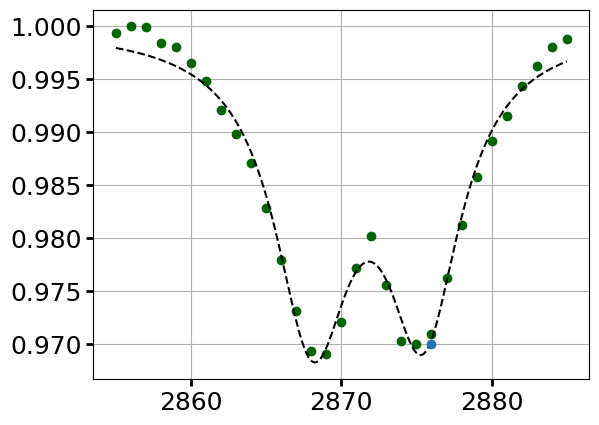

In [10]:
dataODMR = np.loadtxt('C:/Users/JAAL_/Documents/ODMR-jupyter-calculo-magnetometria/Datos-para-magnetometria/odmrsc-corte/ODMR-15dBm.txt')
fmw = dataODMR[:,0]
y = dataODMR[:,1]
# yer = dataODMR[:,2] # el error
gammae = 2.8025

nu_menos_prueba = 2868
nu_mas_prueba = 2875.5

def func(fmw,c1,c2,g1,g2,nu_menos,nu_mas):
	return 1 - c1*(((g1/2)**2)/((fmw-(nu_mas))**2+(g1/2)**2)) - c2*(((g2/2)**2)/((fmw-(nu_menos))**2+(g2/2)**2))

xfit = np.linspace(min(fmw),max(fmw),1000)
parametros_optimos, matriz_covarianza = curve_fit(func, fmw, y, p0=(1,3,3,3,nu_menos_prueba,nu_mas_prueba))

print(parametros_optimos)

plt.plot(fmw,y,'o',color='darkgreen')
# plt.errorbar(fmw,y,yerr=yer, fmt='o',color='navy')
plt.plot(xfit,func(xfit,*parametros_optimos),'--',label = "Fit", color = 'black')
plt.tick_params(direction='out', length=5, width=2, colors='black',labelsize=18)
plt.plot(2876,0.97,'o')
plt.grid()
plt.show()

## Calculo de parametros D y E
Para el caso presente de campo cero se puede calcular del Hamiltoniano del NV las frecuencias $\nu_{\pm} = D \pm E$. Por lo tanto del perfil se puede hallar los siguientes parametros experimentales
\begin{align}
D &= \frac{\nu_{+} + \nu_{-}}{2} \\
E &= \frac{\nu_{+} - \nu_{-}}{2}
\end{align}

In [11]:
D = (nu_mas_prueba + nu_menos_prueba)/2 
E = (nu_mas_prueba - nu_menos_prueba)/2
print(f'D:{D} MHz')
print(f'E:{E} MHz')

D:2871.75 MHz
E:3.75 MHz


# Cargando la data obtenida del experimento para ODMR con campo

C:\Users\JAAL_\AppData\Local\Temp\ipykernel_6136\1045020924.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imag = imread(file[i][j])


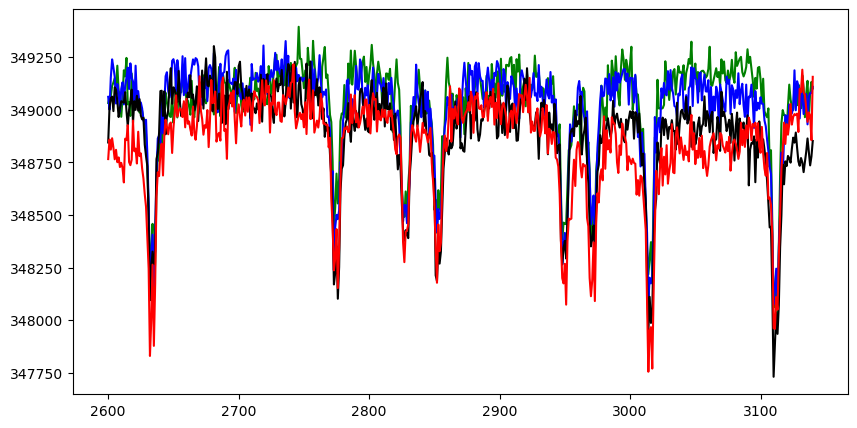

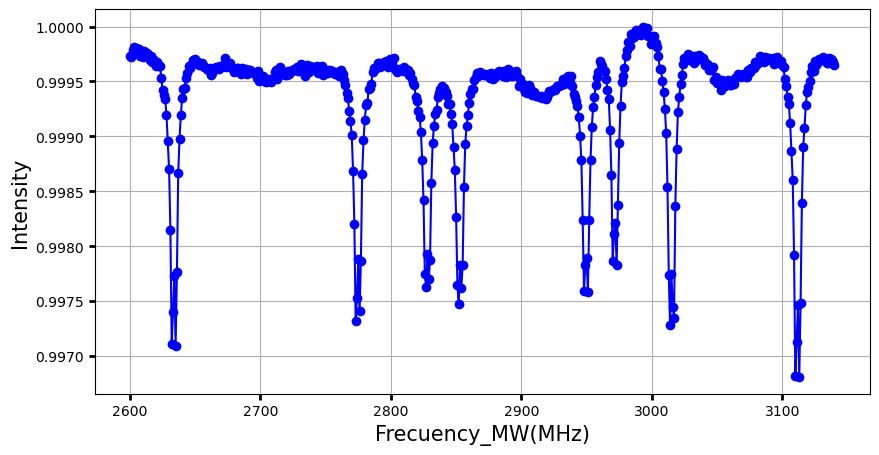

In [12]:
from imageio import imread
import glob

os.chdir('C:/Users/JAAL_/Documents/ODMR-jupyter-calculo-magnetometria/Datos-para-magnetometria/CorteTOTAL/')

nmedias = 64 # Esta variable representa la cantidad de archivos de imágenes que se van a procesar.
# Son en total 34,624 fotos que dividio entre 64 da : 541 fotos por cada numeración de foto
''' Las fotos estan etiquetadas de la siguiente manera 
(numero1)_image_(numero2) 
donde: 
* numero1 = Entre 1-64
* numero2 = Entre 2600-3140
'''
file = list()
for i in range(1,nmedias+1):
    # va a guardar en una lista doble
    '''La función principal que se utiliza en el paquete glob es glob.glob(), que devuelve una lista de rutas de 
    archivos o directorios que coinciden con el patrón especificado.'''
    file.append(glob.glob(str(i)+'_image_*.png')) # se agrega los elementos de file los que coincidan con la (numero1) iteración

#  Se define una función llamada my_range que genera un rango de números similar a la función range(), 
# pero con la posibilidad de especificar un paso diferente de 1.
def my_range(start, end, step):
    while start <= end:
        yield start
        start += step    

# el rango de frecuencias
# El rango de frecuencias de las fotos
x1 = [x for x in my_range(2870-270,2870+270,1)]
      
ODMR = []
for i in range(nmedias): #recorre las fotos
    n = list()
    for j in range(len(x1)): # recorre las frecuencias
        # lee la imagen y crea el array. 
        imag = imread(file[i][j])
        # suma y lo guarda el valor alli.
        n.append(np.sum(imag))
        
    # Al final tiene un array con los valores de intensidad de todas las fotos
    ODMR.append(n)
    
'''
Al final tienes una supermatriz ODMR de nmedias x frecuencias donde cada fila ''i'' representa el numero de foto (numero1) 
y la columna ''j'' representa la frecuencia. 
'''

############## Creamos la imagen con la primera, segunda, tercera y cuarta
plt.figure(figsize = (10,5))
plt.plot(x1,ODMR[0],'-g')
plt.plot(x1,ODMR[1],'-b')
plt.plot(x1,ODMR[2],'-k')
plt.plot(x1,ODMR[3],'-r')
plt.show()


nt = list()
# x1 son las frecuencias. 
# Aqui va a promediar en todas las fotos cada frecuencia
for i in range(len(x1)):
    soma = 0
    for j in range(nmedias):
        soma = soma + ODMR[j][i]
    nt.append(soma) # guarda el promedio para cada frecuencia
    
Nnt = list()
norm = float(max(nt))
for i in range(len(x1)):
    Nnt.append(nt[i]/norm) # normaliza la frecuencia resultante. 

A = []
for i in range(len(x1)):
	A.append([0]*2) # hacer un array con 2 columnas 
for i in range(len(x1)):
	A[i][0] = x1[i] # en la primera columna guarda las frecuencias
	A[i][1] = Nnt[i] # en la segunda columna guarda los PL normalizados

np.savetxt('ODMRCORTETOAL.txt',A,fmt='%s')

plt.figure(figsize = (10,5))
plt.plot(x1,Nnt,'-ob')
plt.tick_params(direction='out', length=4, width=2, colors='black',labelsize=10)
plt.xlabel('Frecuency_MW(MHz)',fontsize=15)
plt.ylabel('Intensity',fontsize=15)
plt.grid()
# plt.savefig("../../Graficos_out/ODMR_normal")
#plt.xlim(2765,2770)
#plt.ylim(0.992,1)
plt.show() 

# ODMR con campo (maximo 8 valles)

## Fitting del ODMR
Este puede ser modelado por una suma de funciones lotenzianas (maximo 8 suma)
$$
\frac{I(f)}{I(0)} = 1 - \sum_{i}C_i \left(\frac{\left(\frac{\Gamma_i}{2}\right)^2}{(f-f_{0,i})-\left(\frac{\Gamma_i}{2}\right)^2} \right)
$$

donde 
- $C_i$, $\Gamma_i$ y $f_{0,i}$ son respectivamente el contraste, el Full-width half-maximum (FWHM) y la frecuencia de resonancia en el valle ''i''. 
- $I(0)$ es la intensidad de fluorescencia lejos de las transiciones de resonancia

### Encontrando las frecuencias de resonancia

Índices de los mínimos locales: [ 35 173 227 252 351 373 414 513]
Valores de los mínimos locales: [0.99708767 0.99731744 0.99762481 0.99746919 0.99757739 0.99782635
 0.99727653 0.9968113 ]
[2635. 2773. 2827. 2852. 2951. 2973. 3014. 3113.]


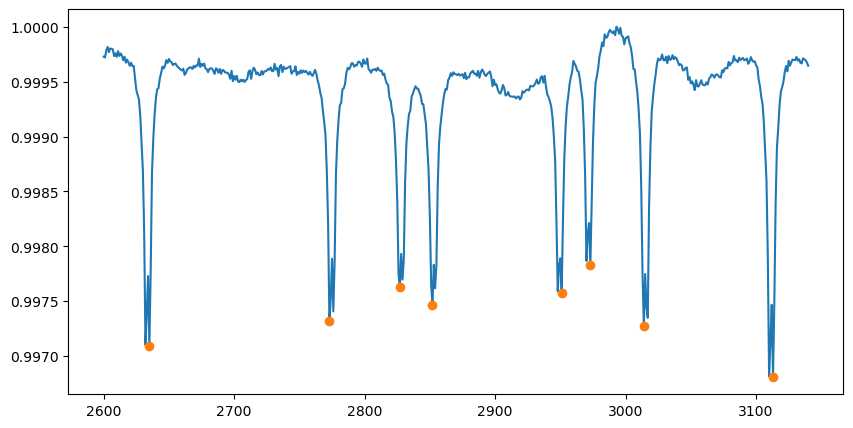

In [13]:
from scipy.signal import find_peaks

# Calculo de minimos
dataODMR = np.loadtxt('C:/Users/JAAL_/Documents/ODMR-jupyter-calculo-magnetometria/Datos-para-magnetometria/CorteTOTAL/ODMRCORTETOAL.txt')
fmw = dataODMR[:,0]
y = dataODMR[:,1]

minimos_locales, _ = find_peaks(-y,distance=5,height=-0.9991)

# Imprimir los índices de los mínimos locales
print("Índices de los mínimos locales:", minimos_locales)

# Imprimir los valores de los mínimos locales
print("Valores de los mínimos locales:", y[minimos_locales])
frecmin = np.array(fmw[minimos_locales])

print(frecmin)

plt.figure(figsize = (10,5))
plt.plot(fmw,y,'-')
plt.plot(fmw[minimos_locales],y[minimos_locales],'o')

### Intentando encontrar las parametrizaciones con los minimos 
**conclusión: Tengo que crear mi propio algoritmo para parametrizar; sin embargo otra solución 
es separar por partes la data y hacer parametrización en cada valle**

**Por otro lado, es necesario?, es decir puedo hallar minimos solo usando una comparación de puntos**

[2.37822782e-03 2.00098125e-03 2.13518639e-03 2.15306545e-03
 1.71693216e-03 1.88489088e-03 2.52117753e-03 2.75096096e-03
 1.04383387e+01 1.36615584e+01 8.90981315e+00 1.09232157e+01
 1.52860044e+01 5.35242606e+00 7.50587726e+00 9.35515143e+00]


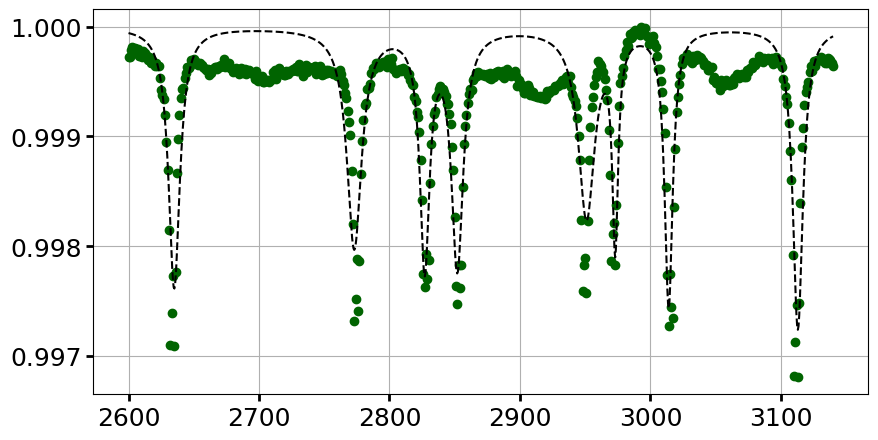

In [14]:
def func_8picos(fmw,c0,c1,c2,c3,c4,c5,c6,c7,g0,g1,g2,g3,g4,g5,g6,g7):
	return 1 - ( c0*(((g0/2)**2)/((fmw-(frecmin[0]))**2+(g0/2)**2))+ \
                 c1*(((g1/2)**2)/((fmw-(frecmin[1]))**2+(g1/2)**2))+ \
                 c2*(((g2/2)**2)/((fmw-(frecmin[2]))**2+(g2/2)**2))+ \
                 c3*(((g3/2)**2)/((fmw-(frecmin[3]))**2+(g3/2)**2))+ \
                 c4*(((g4/2)**2)/((fmw-(frecmin[4]))**2+(g4/2)**2))+ \
                 c5*(((g5/2)**2)/((fmw-(frecmin[5]))**2+(g5/2)**2))+ \
                 c6*(((g6/2)**2)/((fmw-(frecmin[6]))**2+(g6/2)**2))+ \
                 c7*(((g7/2)**2)/((fmw-(frecmin[7]))**2+(g7/2)**2)) )

xfit = np.linspace(min(fmw),max(fmw),1000)
parametros_optimos, matriz_covarianza = curve_fit(func_8picos, fmw, y, p0=(0.003,0.003,0.002,0.002,0.002,0.002,0.002,0.002,5,10,5,5,5,5,5,5))

print(parametros_optimos)

plt.figure(figsize = (10,5))
plt.plot(fmw,y,'o',color='darkgreen')
# plt.errorbar(fmw,y,yerr=yer, fmt='o',color='navy')
plt.plot(xfit,func_8picos(xfit,*parametros_optimos),'--',label = "Fit", color = 'black')
plt.tick_params(direction='out', length=5, width=2, colors='black',labelsize=18)
plt.grid()
plt.show()

### Intentando mejorar el fitting con un modelo cuadratico

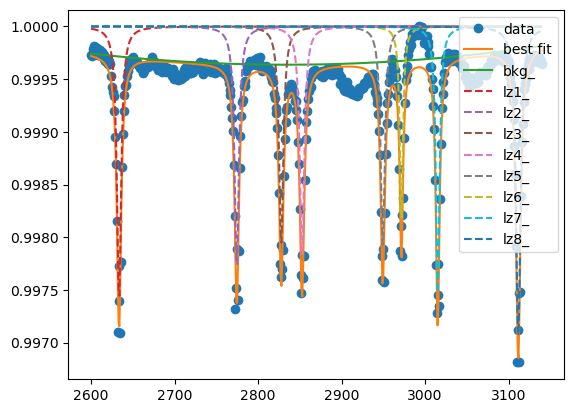

In [15]:
# import matplotlib.pyplot as plt
import numpy as np
# para crear modelos y ajustar datos. LorentzianModel y QuadraticModel son dos tipos 
# de modelos que se utilizan para ajustar los datos.
from lmfit.models import LorentzianModel, QuadraticModel 

# Calculo de minimos
dataODMR = np.loadtxt('C:/Users/JAAL_/Documents/ODMR-jupyter-calculo-magnetometria/Datos-para-magnetometria/CorteTOTAL/ODMRCORTETOAL.txt')
xdat = np.array(dataODMR[:,0])
ydat = np.array(dataODMR[:,1])

def add_peak(prefix, center, amplitude=6, sigma=3):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center)
    pars[prefix + 'amplitude'].set(amplitude)
    pars[prefix + 'sigma'].set(sigma, min=0)
    return peak, pars

model = QuadraticModel(prefix='bkg_')
params = model.make_params(a=0, b=0, c=0)

rough_peak_positions = (2635, 2773, 2827, 2852, 2951, 2973, 3014, 3113)
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak('lz%d_' % (i+1), cen)
    model = model + peak
    params.update(pars)

init = model.eval(params, x=xdat)
result = model.fit(ydat, params, x=xdat)
comps = result.eval_components()

# print(result.fit_report(min_correl=0.5))

plt.plot(xdat, ydat,'o', label='data')
plt.plot(xdat, result.best_fit, label='best fit')
for name, comp in comps.items():
    if name == 'bkg_':
        plt.plot(xdat,comps['bkg_'], label='bkg_')
    else:
        plt.plot(xdat, comp + 1, '--', label=name)
plt.legend(loc='upper right')
plt.show()

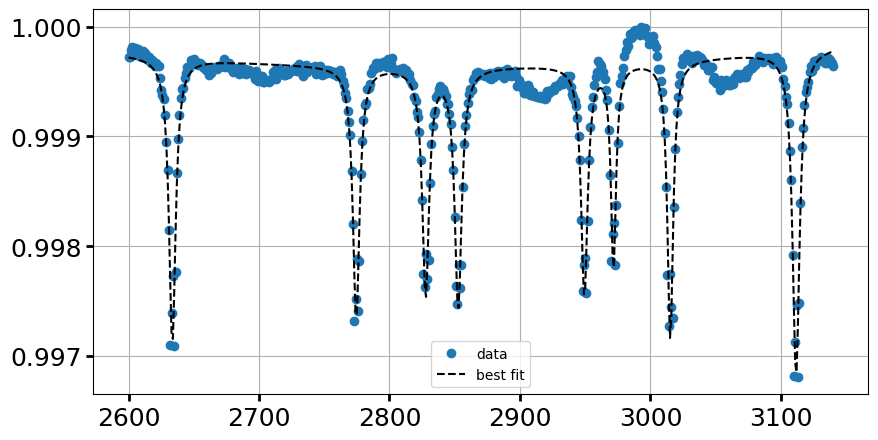

In [16]:
plt.figure(figsize = (10,5))
plt.plot(xdat, ydat,'o', label='data')
plt.plot(xdat, result.best_fit,'--', label='best fit',color='black')
plt.tick_params(direction='out', length=5, width=2, colors='black',labelsize=18)
plt.legend(loc='lower center')
plt.grid()
plt.show()

## Sensibilidad del campo magnetico
De estos parametros se puede calcular la sensibilidad magnetica $\eta$ de la tecnica ODMR

$$
\eta = \frac{4h}{3\sqrt{3}g_e \mu_B} \frac{\Gamma}{C\sqrt{I(0)}}
$$

donde: 
- $\mu_B = 9.27 \cdot 10^{-24}$ J.T^{-1}
- $g_e = 2.0023$ 
- $h = 6.626 \cdot 10^{-34}$ J.s

## Extraemos solo una parte de la data de ODMR con campo

[2.35108911e-03 6.78676775e+00 2.77453797e+03]


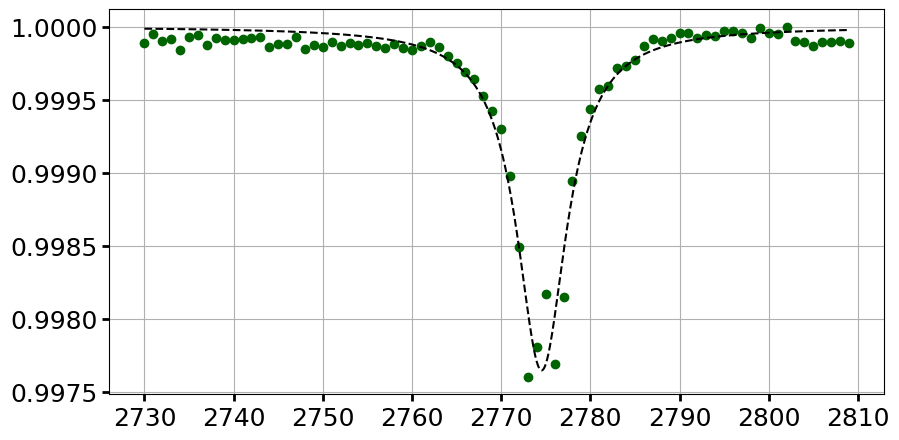

In [17]:
fmw = dataODMR[130:210,0]
y = dataODMR[130:210,1]/max(dataODMR[130:210,1])

nu = 0

def func(fmw,C,gamma,nu):
	return 1 - C*((gamma/2)**2)/((fmw-(nu))**2+(gamma/2)**2)

xfit = np.linspace(min(fmw),max(fmw),1000)
parametros_optimos, matriz_covarianza = curve_fit(func, fmw, y, p0=(1,3,2775))

print(parametros_optimos)

plt.figure(figsize = (10,5))
plt.plot(fmw,y,'o',color='darkgreen')
plt.plot(xfit,func(xfit,*parametros_optimos),'--',label = "Fit", color = 'black')
plt.tick_params(direction='out', length=5, width=2, colors='black',labelsize=18)
plt.grid()
plt.show()

## Calculo del campo magnetico de las frecuencias de transición $f_{0,i}$

### Sistemas de referencia
(incluir grafico //// pendiente) 

Tenemos 2 sistemas de referencia 
1. Sistema laboratorio: $(x,y,z)$ donde los ejes coinciden perpendicular al borde de la placa de diamante y como este (la muestra) tiene orientación cristalina (1,0,0) en la superficie superior entonces se tiene que el ''eje z'' coincide perpedicular a la superficie superior del diamante (ver grafico)

\begin{align}
\vec{e_x} &= (1,0,0) \\
\vec{e_y} &= (0,1,0) \\
\vec{e_z} &= (0,0,1) 
\end{align}

La base de este sistema laboratorio es $B = \{ \vec{e_x}, \vec{e_y}, \vec{e_z} \}$

2. Sistema NV: $(x',y',z')$ aqui este sistema tiene los ejes alienados a los 3 de 4 de los ejes NV. Las 4 direcciones cristalograficas de los ejes NV estan dados por (Ver grafico, el calculo no es complicado, solo requiere recordar la estructura fcc del diamante)

\begin{align}
\vec{n}_1 &= \frac{1}{\sqrt{3}}(1,-1,-1) \\
\vec{n}_2 &= \frac{1}{\sqrt{3}}(-1,1,-1)  \\
\vec{n}_3 &= \frac{1}{\sqrt{3}}(-1,-1,1) \\
\vec{n}_4 &= \frac{1}{\sqrt{3}}(1,1,1) 
\end{align}

La base de este sistema NV se escoge $B' = \{ \vec{n_1}, \vec{n_2}, \vec{n_3} \}$

In [18]:
baseB = np.eye(3)
baseB_ = 1/np.sqrt(3)*np.array([[1,-1,-1],[-1,1,-1],[-1,-1,1],[1,1,1]])

### Matriz cambio de base
Hallamos la matriz de cambio de base $M_{BB'}: B' \rightarrow B$
$$
M_{BB'} = \frac{1}{\sqrt{3}}\begin{bmatrix}  1 & -1 & -1 \\ -1 & 1 & -1 \\ -1 & -1 & 1 \end{bmatrix} \qquad M_{B'B} = M_{BB'}^{-1} = \frac{\sqrt{3}}{2}\begin{bmatrix}  0 & -1 & -1 \\ -1 & 0 & -1 \\ -1 & -1 & 0 \end{bmatrix}
$$

In [19]:
MBB_ = 1/np.sqrt(3)*np.array([[1,-1,-1],[-1,1,-1],[-1,-1,1]])
MB_B = np.sqrt(3)/2*np.array([[0,-1,-1],[-1,0,-1],[-1,-1,0]])

### Hallando el campo magnetico en sistema NV
- El campo magnetico respecto al sistema NV es $\vec{B} = B'_x\vec{n}_1 + B'_y\vec{n}_2 + B'_z\vec{n}_3$ donde

aqui $\theta_i$ es el angulo que forma $\vec{B}$ con $\vec{n}_i$ y debido a propiedad de simetria $\vec{n}_1 + \vec{n}_2 + \vec{n}_3 + \vec{n}_4$ se tiene 4 ecuaciones para resolver (podemos tomar solo 3)

\begin{align}
   B &\cdot \vec{n}_1 = B cos(\theta_1) \\
   B &\cdot \vec{n}_2 = B cos(\theta_2) \\
   B &\cdot \vec{n}_3 = B cos(\theta_3) \\
   B &\cdot \vec{n}_4 = B cos(\theta_4) 
\end{align}

Aqui los valores $\{B,\theta_1,\theta_2,\theta_3,\theta_4\}$ se halla de las siguientes formulas

\begin{align}
B &= \frac{h}{g_e \mu_B}\left(\frac{1}{3}\left[ (f_{+i}^2 + f_{-i}^2 - f_{+i}f_{-i} - D^2) \right]-E^2 \right)^{1/2} \\
\cos(2\theta_i) &= \frac{7D^3 + 2(f_{+i} + f_{-i})\left[2(f_{+i}^2 + f_{-i}^2) -5f_{+i}f_{-i} \right] -3D(f_{+i}^2 + f_{-i}^2 -f_{+i}f_{-i}+9E^2)}{9D(f_{+i}^2 + f_{-i}^2 - f_{+i}f_{-i} - D^2 - 3E^2)}
\end{align}

donde i es uno de los 4 pares de picos del ODMR con campo (Ver figura)

(adjuntar figura de 4 pares picos ODMR ///// pendiente ) 

#### Campo magnetico / Modulo

\begin{align}
B &= \frac{h}{g_e \mu_B}\left(\frac{1}{3}\left[ (f_{+i}^2 + f_{-i}^2 - f_{+i}f_{-i} - D^2) \right]-E^2 \right)^{1/2}
\end{align}

In [4]:
h = 6.626*10**(-34)
ge = 2.0023
mu_B  = 9.27 * 10**(-24)

hgemuB = (h/(ge*mu_B))**(-1)
hgemuB * 10**(-9)

28.012859945668577

In [20]:
h = 6.626*10**(-34)
ge = 2.0023
mu_B  = 9.27 * 10**(-24)

hgemuB = h/(ge*mu_B)
display(frecmin)

## Hallando el modulo de campo magnetico
B = []
for i in range(1,5):
    # El 10**(6) es para hacer cuentas de MHz
    Bvalor = hgemuB*10**(6)*( 1/3*(frecmin[i-1]**2 + frecmin[-i]**2 - frecmin[i-1]*frecmin[-i] - D**2) - E**2 )**(1/2)
    B.append(Bvalor)
display(B)

Bcalc = np.array(B).mean()

print(f'B:{Bcalc*10**3} mT')

array([2635., 2773., 2827., 2852., 2951., 2973., 3014., 3113.])

[0.00884675902460994,
 0.00847057981414724,
 0.008719759273345529,
 0.008721366707758707]

B:8.689616204965354 mT


#### Hallando los cosenos

\begin{align}
\cos(2\theta_i) &= \frac{7D^3 + 2(f_{+i} + f_{-i})\left[2(f_{+i}^2 + f_{-i}^2) -5f_{+i}f_{-i} \right] -3D(f_{+i}^2 + f_{-i}^2 -f_{+i}f_{-i}+9E^2)}{9D(f_{+i}^2 + f_{-i}^2 - f_{+i}f_{-i} - D^2 - 3E^2)}
\end{align}


In [21]:
## Hallando los coseno de theta
costhetalist = []
for i in range(1,5):
    # El 10**(6) es para hacer cuentas de MHz
    cos2theta = ( 7*D**3 + 2*(frecmin[i-1] + frecmin[-i])*(2*(frecmin[i-1]**2 + frecmin[-i]**2) - 5*frecmin[i-1]*frecmin[-i]) - 3*D*(frecmin[i-1]**2 + frecmin[-i]**2 - frecmin[i-1]*frecmin[-i] + 9*E**2)   ) \
                    / ( 9*D*(frecmin[i-1]**2 + frecmin[-i]**2 - frecmin[i-1]*frecmin[-i] -D**2-3*E**2)  )
    
    
    costheta = np.cos(np.arccos(cos2theta)/2)
    costhetalist.append(costheta)

np.array(costhetalist)

array([0.96452629, 0.50794013, 0.29693197, 0.19859557])

#### Haciendo match de los valles con los $\theta_i$ (indeterminado) 

\begin{align} 
   B &\cdot \vec{n}_1 = B'_x \; \vec{n}_1 \cdot \vec{n}_1 + B'_y \; \vec{n}_1 \cdot \vec{n}_2 + B'z \; \vec{n}_1 \cdot \vec{n}_3 =   B cos(\theta_1) \\
   B &\cdot \vec{n}_2 = B'_x \; \vec{n}_2 \cdot \vec{n}_1 + B'_y \; \vec{n}_2 \cdot \vec{n}_2 + B'z \; \vec{n}_2 \cdot \vec{n}_3 = B cos(\theta_2) \\
   B &\cdot \vec{n}_3 = B'_x \; \vec{n}_3 \cdot \vec{n}_1 + B'_y \; \vec{n}_3 \cdot \vec{n}_2 + B'z \; \vec{n}_3 \cdot \vec{n}_3 = B cos(\theta_3) \\
   B &\cdot \vec{n}_4 = B'_x \; \vec{n}_4 \cdot \vec{n}_1 + B'_y \; \vec{n}_4 \cdot \vec{n}_2 + B'z \; \vec{n}_4 \cdot \vec{n}_3 = B cos(\theta_4) 
\end{align}

In [47]:
# Coeficientes de las variables en las ecuaciones
coeficientes = np.array([[baseB_[0] @ baseB_[0].T, baseB_[0] @ baseB_[1].T, baseB_[0] @ baseB_[2].T],
                         [baseB_[1] @ baseB_[0].T, baseB_[1] @ baseB_[1].T, baseB_[1] @ baseB_[2].T],
                         [baseB_[2] @ baseB_[0].T, baseB_[2] @ baseB_[1].T, baseB_[2] @ baseB_[2].T]])

# Términos independientes
independientes = np.array([Bcalc*costhetalist[0], Bcalc*costhetalist[1], Bcalc*costhetalist[2]])
# Resolver el sistema de ecuaciones
solucion = np.linalg.solve(coeficientes, independientes)

# Imprimir la solución
print("La solución del sistema de ecuaciones es:")
print("B'x =", solucion[0])
print("B'y =", solucion[1])
print("B'z =", solucion[2])


Bx_ = solucion[0]
By_ = solucion[1]
Bz_ = solucion[2]

BsistemaNV = np.array([[Bx_, By_, Bz_]])
BsistemaNV

La solución del sistema de ecuaciones es:
B'x = 0.01781756712251998
B'y = 0.014841898224969282
B'z = 0.013466713315436847


array([[0.01781757, 0.0148419 , 0.01346671]])

### Hallando el campo magnetico en el sistema laboratorio
- El campo magnetico respecto al sistema laboratorio es $\vec{B} = B_x \vec{e}_x + B_y \vec{e}_y + B_z \vec{e}_z$ 
- El campo magnetico respecto al sistema NV es $\vec{B} = B'_x\vec{n}_1 + B'_y\vec{n}_2 + B'_z\vec{n}_3$

Ambos campos magneticos estan relacionados 
\begin{equation}
\begin{bmatrix} B_x \\ B_y \\ B_z \end{bmatrix} = \frac{1}{\sqrt{3}}\begin{bmatrix}  1 & -1 & -1 \\ -1 & 1 & -1 \\ -1 & -1 & 1 \end{bmatrix} \begin{bmatrix} B'_x \\ B'_y \\ B'_z \end{bmatrix}
\end{equation}

In [48]:
Blab = ( MBB_ @ BsistemaNV.T ).T
display(Blab*10**3) # En mT se obtiene multiplicando x 10^3

(Blab @ Blab.T)**(1/2)

array([[ -6.05700732,  -9.4930138 , -11.08094055]])

array([[0.01579848]])

### Usando un algoritmo para aprovechar las 4 ecuaciones

In [46]:
# Definir la matriz de coeficientes A (4 ecuaciones y 3 incógnitas)
A = np.array([[baseB_[0] @ baseB_[0].T, baseB_[0] @ baseB_[1].T, baseB_[0] @ baseB_[2].T],
            [baseB_[1] @ baseB_[0].T, baseB_[1] @ baseB_[1].T, baseB_[1] @ baseB_[2].T],
            [baseB_[2] @ baseB_[0].T, baseB_[2] @ baseB_[1].T, baseB_[2] @ baseB_[2].T],
            [baseB_[3] @ baseB_[0].T, baseB_[3]@ baseB_[1].T, baseB_[3] @ baseB_[2].T]])

# Definir el vector de términos independientes b
b = np.array([Bcalc*costhetalist[0], Bcalc*costhetalist[1], Bcalc*costhetalist[2],Bcalc*costhetalist[3]])

# Resolver el sistema usando mínimos cuadrados
solution, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)

print("Solución: ", solution)
print("Residuos: ", residuals)
print("Rango de la matriz: ", rank)
print("Valores singulares: ", singular_values)

# Imprimir la solución
print("La solución del sistema de ecuaciones es:")
print("B'x =", solution[0])
print("B'y =", solution[1])
print("B'z =", solution[2])

Bx_ = solution[0]
By_ = solution[1]
Bz_ = solution[2]

BsistemaNV = np.array([[Bx_, By_, Bz_]])
BsistemaNV

Blab = ( MBB_ @ BsistemaNV.T ).T
display(Blab*10**3) # En mT se obtiene multiplicando x 10^3

(Blab @ Blab.T)**(1/2)

Solución:  [0.00499173 0.00201606 0.00064088]
Residuos:  [7.31120097e-05]
Rango de la matriz:  3
Valores singulares:  [1.33333333 1.33333333 0.66666667]
La solución del sistema de ecuaciones es:
B'x = 0.0049917329659740495
B'y = 0.0020160640684233496
B'z = 0.0006408791588909135


array([[ 1.34799148, -2.08801499, -3.67594175]])

array([[0.00443728]])